In [100]:
!pip install timm -Uqq

In [101]:
from torchmetrics import AUROC  # For AUC metric
import time  # For timing epochs
from typing import Dict, List, Tuple, Any, Optional
import math  # For floor operation
from torch.cuda.amp import autocast, GradScaler  # For mixed precision
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import LambdaLR  # For custom LR scheduling
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiplicativeLR
from typing import Tuple
from torch.utils.data import Dataset
from typing import Any, Callable, Dict, List, Tuple
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from typing import Tuple, Dict
from tqdm.notebook import tqdm  # Assuming tqdm is available in the environment
from typing import List, Dict
import cv2
import pydicom
from typing import List
from typing import List, Optional, Callable
from IPython.display import display, HTML
import subprocess
import logging
import concurrent.futures
from tqdm.notebook import tqdm
import cv2      # Image processing
import pydicom  # DICOM file handling
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import json
import time
import gc
import random
import pandas as pd
import numpy as np
from torchmetrics import Accuracy, AUROC
import torchmetrics
import timm  # State-of-the-art pretrained models
from torchvision import datasets, transforms as t
import torchvision
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, GradientAccumulationScheduler, StochasticWeightAveraging, BackboneFinetuning
import pytorch_lightning as pl
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torch
import warnings
import os
import torch
from torch.utils.data import Dataset, WeightedRandomSampler
from collections import Counter
from typing import Optional # For the return type hint


warnings.filterwarnings("ignore", category=RuntimeWarning)

# Suppresses all TF messages except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [102]:
# dataset_parent=Path.home().parent/"kaggle"/"input"
# output_directory=Path.home().parent/"kaggle"/"working"

In [103]:
# print(dataset_parent)
# print(output_directory)

In [104]:
# batch_size = 64
# num_workers = os.cpu_count()
# # Define consistent project paths
# HOME = Path.home()
# BASE_PATH = dataset_parent / "rsna-pneumonia-detection-challenge"
# ROOT_PATH = BASE_PATH / "stage_2_train_images"
# SAVE_PATH = output_directory / "Processed"

In [105]:
# for directory in [(output_directory/"logs"), SAVE_PATH]:
#     shutil.rmtree(directory, ignore_errors=True)  # Remove existing directory if it exists

In [106]:
# os.makedirs("/root/.config/kaggle", exist_ok=True)
# list(Path("/root/.config/kaggle").iterdir())

In [107]:
# kaggle_json = {"username": "aliserwat",
#                "key": "40f7391ca0ff0d8a66ebed0fb071a2d3"}


# conf_folder = '/root/.config/kaggle'
# os.makedirs(conf_folder, exist_ok=True)
# kaggle_json_path = os.path.join(conf_folder, "kaggle.json")


# with open(kaggle_json_path, "w") as f:
#     json.dump(kaggle_json, f)

# os.chmod(kaggle_json_path, 0o600)

In [108]:
batch_size = 64
num_workers = os.cpu_count()
# Define consistent project paths
HOME = Path.home()
BASE_PATH = Path.cwd() / "Pneumonia"
ROOT_PATH = BASE_PATH / "stage_2_train_images"
SAVE_PATH = Path.cwd() / "Processed"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
# shutil.rmtree(SAVE_PATH, ignore_errors=True)

In [110]:
# Ensure all necessary directories exist
for path in [BASE_PATH, ROOT_PATH, SAVE_PATH]:
    if not path.exists():
        print(f"Creating directory: {path}")
        os.makedirs(path, exist_ok=True)

# Define zip file path in BASE_PATH
# zip_path = HOME / "rsna-pneumonia-detection-challenge.zip"

# if zip_path.exists():
#     print(f"Zip file already exists at {zip_path}")
# else:
#     try:
#         subprocess.run(["kaggle", "--version"], capture_output=True, check=True)
#         print(f"Downloading dataset to {HOME} ...")
#         subprocess.run([
#             "kaggle", "competitions", "download",
#             "-c", "rsna-pneumonia-detection-challenge",
#             "-p", str(HOME)
#         ], check=True)
#         if zip_path.exists():
#             print(f"Extracting {zip_path.name} to {BASE_PATH} ...")
#             subprocess.run([
#                 "unzip", "-o", str(zip_path), "-d", str(BASE_PATH)
#             ], check=True)
#         else:
#             print(f"Zip file not found at {zip_path}")
#     except FileNotFoundError:
#         print("Error: Kaggle CLI not found. Please install it using:")
#         print("pip install kaggle")
#         print("\nAfter installation, ensure your API credentials are configured:")
#         print("1. Create an API token from https://www.kaggle.com/settings/account")
#         print("2. Place kaggle.json in ~/.kaggle/ directory")
#         print("3. Run: chmod 600 ~/.kaggle/kaggle.json")
#     except subprocess.CalledProcessError as e:
#         print(f"Command failed with return code {e.returncode}")
#         print(f"Error output: {e.stderr.decode() if e.stderr else 'None'}")

In [111]:
from pathlib import Path
from IPython.display import HTML, display

try:
    BASE_PATH
except NameError:
    BASE_PATH = Path("./")  # Default if BASE_PATH is not defined

# 💡 Inspecting the file system "cabinets" (directories) and "loose reports" (files)
all_items = list(BASE_PATH.iterdir())
directories = [item.name for item in all_items if item.is_dir()]
files = [item.name for item in all_items if item.is_file()]

# 🎨 Richer HTML output for better visual distinction (theme-aware colors)
html_output = ""

# 📂 Directories Section
if directories:
    # A shade of blue for the header
    dir_html = '<span style="color:#6699CC; font-weight:bold; font-size:1.2em;">📁 Directories:</span><br>'
    for directory in sorted(directories):  # Sort for consistent output
        # A lighter shade of blue for individual directories
        dir_html += f'<span style="color:#8FBC8F;">&nbsp;&nbsp;📂 {directory}</span><br>'
    html_output += dir_html

# Separator if both directories and files exist
if directories and files:
    # A neutral gray for the separator
    html_output += '<br><span style="color:#A9A9A9;">---</span><br>'

# 📄 Files Section
if files:
    # Same header style
    file_html = '<span style="color:#6699CC; font-weight:bold; font-size:1.2em;">📄 Files:</span><br>'
    for file in sorted(files):  # Sort for consistent output
        # A shade of orange/yellow for individual files
        file_html += f'<span style="color:#FFD700;">&nbsp;&nbsp;📄 {file}</span><br>'
    html_output += file_html

# 🧠 Display the organized and colored output
display(HTML(html_output))

In [112]:
labels = pd.read_csv(BASE_PATH / "stage_2_train_labels.csv")

In [113]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [114]:
# labels = pd.read_csv("./stage_2_train_labels.csv")
# labels.head()

In [115]:
# Define columns that contribute to the completeness score, excluding 'patientId'.
columns_for_completeness = [col for col in labels.columns if col != 'patientId']

# Deduplicate labels by keeping the row with the highest non-null count per patient.
labels_deduplicated = (
    labels.assign(nonnull_count=labels[columns_for_completeness].notnull().sum(axis=1))
    .sort_values(by=["patientId", "nonnull_count"], ascending=[True, False])
    .drop_duplicates(subset="patientId", keep="first")
    .drop(columns="nonnull_count")
)


In [116]:
import pandas as pd

# Assuming 'labels' is your DataFrame
# Example: labels = pd.read_csv("stage_2_train_labels.csv")

# Calculate the non-null count for all relevant columns
relevant_columns = labels.columns.tolist()  # Or a specific subset
labels['nonnull_count'] = labels[relevant_columns].notnull().sum(axis=1)

# Find the index of the row with the maximum non-null count for each patientId
max_nonnull_index = labels.groupby("patientId")['nonnull_count'].idxmax()

# Select the rows using these indices and drop the temporary column
deduplicated_labels = labels.loc[max_nonnull_index].drop(columns='nonnull_count')

# Reset index for the final DataFrame
deduplicated_labels.reset_index(drop=True, inplace=True)


In [117]:

# Now 'labels_deduplicated' holds the result.
# If you want to update the original 'labels' DataFrame:
labels = labels_deduplicated

In [118]:
print("Handled potential label inconsistencies by keeping the most complete entry per patient.\n\n")
print(f"Shape of the processed labels DataFrame: {labels.shape}\n\n")
labels.head()

Handled potential label inconsistencies by keeping the most complete entry per patient.


Shape of the processed labels DataFrame: (26684, 6)




,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1
28994,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0,160.0,373.0,608.0,1


In [119]:
def get_balanced_dataset(df: pd.DataFrame, ratio: int, target_column: str, id_column: str) -> pd.DataFrame | List:
    """
    Creates a subset of the DataFrame to balance classes based on a given ratio.

    Args:
        df: The input pandas DataFrame.
        ratio: The ratio of negative to positive samples. If > 1, it balances by subsampling negatives.
               Otherwise, it returns a shuffled list of unique values from the target column.
        target_column: The name of the column containing the target labels (e.g., 0 and 1).
        id_column: The name of the column containing unique identifiers (e.g., 'patientId').

    Returns:
        A balanced pandas DataFrame or a shuffled list of unique target values.

    Raises:
        ValueError: If the specified target or ID columns are missing from the DataFrame.
    """
    required_columns = {target_column, id_column}
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")

    positive_ids: List[str] = df.loc[df[target_column]
                                     == 1, id_column].sample(frac=1).tolist()
    negative_ids: List[str] = df.loc[df[target_column]
                                     == 0, id_column].sample(frac=1).tolist()

    if ratio > 1:
        positive_count = len(positive_ids)
        negative_count = len(negative_ids)
        group_count = min(positive_count, negative_count // ratio)
        id_list: List[str] = []
        negative_index = 0
        for positive_index in range(group_count):
            id_list.append(positive_ids[positive_index])
            for _ in range(ratio):
                if negative_index < negative_count:
                    id_list.append(negative_ids[negative_index])
                    negative_index += 1
        return df[df[id_column].isin(id_list)].reset_index(drop=True)
    else:
        return df[target_column].drop_duplicates().sample(frac=1).tolist()

# Example of how you might use it:
# Assuming 'labels' is your DataFrame, 'Target' is the target column, and 'patientId' is the ID column
# balanced_df = get_balanced_dataset(labels.copy(), ratio=3, target_column='Target', id_column='patientId')
# print(balanced_df.head())

In [120]:
train_dcm_path = sorted(ROOT_PATH.rglob("*.dcm"))

In [121]:
ROOT_PATH

PosixPath('/teamspace/studios/this_studio/Pneumonia/stage_2_train_images')

In [122]:
len(train_dcm_path), len(labels)

(26684, 26684)

In [123]:
pydicom.dcmread(train_dcm_path[0]).pixel_array.shape

(1024, 1024)

In [124]:
patient_id = "15c262ab-4ec6-4b19-8172-3aaf662e05c3"
labels.loc[
    labels['patientId'] == patient_id, 'Target'
].values.item()

0

In [125]:
def visualize_dicom_images(
    train_dcm_paths: List[Path],
    labels_df: pd.DataFrame,
    grid_rows: int = 2,
    grid_cols: int = 2,
    dpi: int = 200
) -> None:
    """
    Displays a grid of randomly selected DICOM images from the training set,
    along with their corresponding pneumonia labels.

    Args:
        train_dcm_paths: A list of Path objects pointing to the DICOM image files.
        labels_df: A pandas DataFrame containing 'patientId' and 'Target' columns.
        grid_rows: Number of rows in the subplot grid.
        grid_cols: Number of columns in the subplot grid.
        dpi: Dots per inch for the figure resolution.
    """
    # 🧠 Pre-process labels for efficient lookup
    # Create a dictionary mapping patientId to Target for fast O(1) lookups.
    # This avoids repeated DataFrame indexing inside the loop, significantly speeding up label retrieval.
    patient_id_to_label: Dict[str, int] = labels_df.set_index('patientId')[
        'Target'].to_dict()

    # 📊 Determine the maximum index for random selection from the training paths.
    # This assumes 80% of the data is considered 'training' for visualization purposes,
    # consistent with the original code's `len(train_dcm_path)*0.8`.
    max_train_idx = int(len(train_dcm_paths) * 0.8)
    # Ensure at least one image can be picked if list is small
    if max_train_idx == 0 and len(train_dcm_paths) > 0:
        max_train_idx = 1
    elif max_train_idx == 0:  # Handle empty list
        print("Warning: No DICOM paths provided for visualization.")
        return

    # 🖼️ Create a grid of subplots for image display.
    # The `figsize` is adjusted based on `dpi` and grid dimensions for better visual quality.
    fig, ax = plt.subplots(grid_rows, grid_cols, dpi=dpi,
                           figsize=(grid_cols * 3, grid_rows * 3))

    # Flatten the axes array for easier iteration if it's a multi-dimensional grid.
    # If it's a single subplot (e.g., 1x1), `ax` might not be an array, so handle that.
    axes_flat = ax.flatten() if isinstance(ax, np.ndarray) else [ax]

    # 🔄 Iterate through each subplot position to display an image.
    for i, current_ax in enumerate(axes_flat):
        # 🎲 Select a random index within the training data range.
        random_idx = np.random.randint(0, max_train_idx)
        dcm_path = train_dcm_paths[random_idx]

        # 🩻 Read the DICOM image and resize it.
        try:
            dicom_data = pydicom.dcmread(str(dcm_path)).pixel_array
            # Resize the pixel array to a consistent size (256x256).
            resized_image = cv2.resize(dicom_data, (256, 256))
        except Exception as e:
            print(
                f"Error reading or processing DICOM file {dcm_path.name}: {e}")
            # Skip this subplot if there's an error
            current_ax.axis('off')
            current_ax.set_title("Error loading image",
                                 fontsize=8, color='red')
            continue

        # 🆔 Extract the patient ID from the file name.
        patient_id = dcm_path.stem  # .stem gets the filename without extension

        # 🏷️ Retrieve the label for the current patient ID.
        # Use .get() with a default value to handle cases where patient_id might not be in labels_df.
        # -1 as a placeholder for unknown/missing
        label_val = patient_id_to_label.get(patient_id, -1)

        # 📝 Determine the display label based on the target value.
        if label_val == 0:
            display_label = "Healthy"
            title_color = 'green'
        elif label_val == 1:
            display_label = "Pneumonia Patient"
            title_color = 'red'
        else:
            display_label = "Unknown Label"
            title_color = 'gray'

        # 🎨 Display the image and set the title.
        # 'bone' colormap is common for medical images
        current_ax.imshow(resized_image, cmap='bone')
        # Hide axes ticks and labels for cleaner image display
        current_ax.axis('off')
        current_ax.set_title(
            f"ID: {patient_id}\n{display_label}", fontsize=8, color=title_color)

    # 📏 Adjust subplot parameters for a tight layout, preventing titles/labels from overlapping.
    plt.tight_layout()
    # 🖥️ Display the plot.
    plt.show()

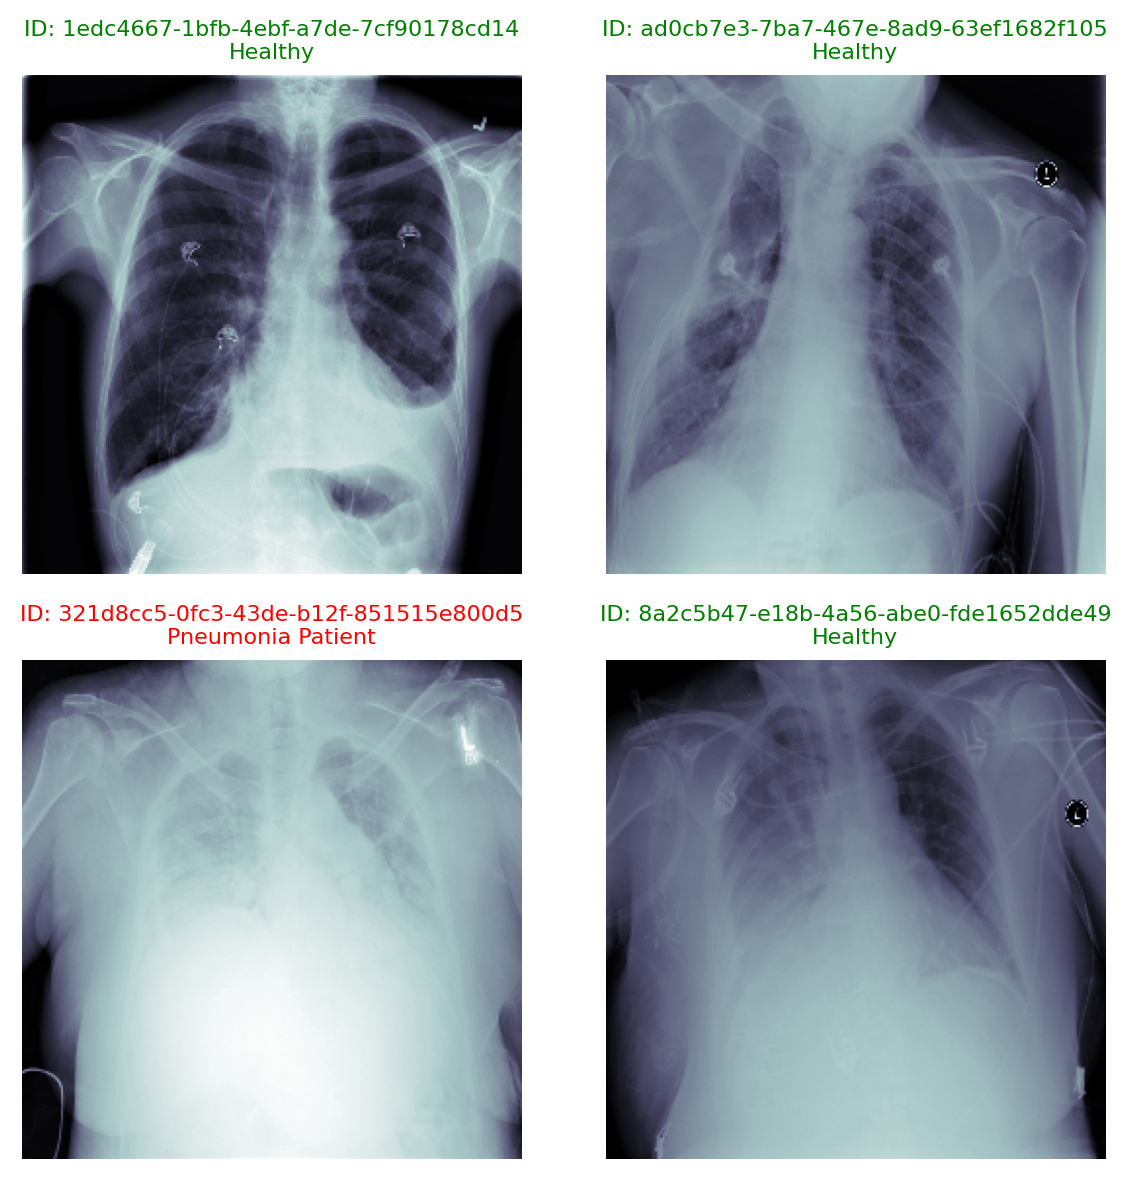

In [126]:
visualize_dicom_images(train_dcm_path, labels)

### ⚙️ Preprocessing the RSNA Pneumonia Detection Challenge Dataset

Let's dive into the preprocessing steps for the chest X-ray (CXR) images in the RSNA pneumonia detection challenge. A crucial initial step is the normalization of pixel values. This helps our models learn more effectively by ensuring the input data has a consistent scale.

#### 🔢 Normalization Statistics

To normalize the pixel values, we first calculate the mean and standard deviation across the entire training dataset. These statistics provide a global view of the pixel intensity distribution.

Mathematically, if we denote the set of all pixel values in the training set as $P = \{p_1, p_2, ..., p_N\}$, where $N$ is the total number of pixels, then the global mean ($\mu$) and standard deviation ($\sigma$) are calculated as:

$$
\mu = \frac{1}{N} \sum_{i=1}^{N} p_i
$$

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (p_i - \mu)^2}
$$

Based on our analysis of the RSNA training data:

$$
\begin{aligned}
\mu_{\text{training}} &\approx 0.4907 \\
\sigma_{\text{training}} &\approx 0.2479
\end{aligned}
$$

Specifically, the provided statistics are:

$$
\begin{aligned}
\mu_{\text{training}} &= 0.49072849471859337 \\
\sigma_{\text{training}} &= 0.24792789306246266
\end{aligned}
$$

And the total number of pixels considered in this calculation is:

* Total pixels in training set: $1,398,996,992$

#### 💡 Why Normalization?

Imagine each pixel as a tiny light bulb, and its value represents its brightness. If some images have generally dimmer bulbs and others much brighter ones, our AI model might get confused, focusing on the overall brightness rather than the subtle patterns indicative of pneumonia.

Normalization acts like adjusting all the light switches so that the average brightness and the range of brightness are similar across all images. This allows the model to concentrate on the actual structures and anomalies within the CXRs.

The most common normalization technique involves subtracting the mean and dividing by the standard deviation:

$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

Where $x$ is the original pixel value and $x_{\text{normalized}}$ is the normalized pixel value. This transformation results in data with a mean of approximately 0 and a standard deviation of approximately 1.

#### 💻 PyTorch Implementation Snippet

Here's a simple PyTorch snippet demonstrating how you might apply this normalization to a batch of CXR images:

```python
import torch

def normalize_batch(img_batch, mean, std):
    """Normalizes a batch of images using the provided mean and standard deviation.

    Args:
        img_batch (torch.Tensor): A batch of images (e.g., shape [batch_size, channels, height, width]).
        mean (float): The global mean of the training data.
        std (float): The global standard deviation of the training data.

    Returns:
        torch.Tensor: The normalized batch of images.
    """
    normalized_batch = (img_batch - mean) / std
    return normalized_batch

# Example usage (assuming 'cxr_batch' is your image tensor)
mean_val = 0.49072849471859337
std_val = 0.24792789306246266
normalized_cxr_batch = normalize_batch(your_cxr_batch_tensor, mean_val, std_val)
print(f"Shape of normalized batch: {normalized_cxr_batch.shape}")
print(f"Mean of normalized batch (approx.): {torch.mean(normalized_cxr_batch).item():.4f}")
print(f"Std of normalized batch (approx.): {torch.std(normalized_cxr_batch).item():.4f}")

In [127]:
def normalize_img(
    ROOT_PATH: Path,
    SAVE_PATH: Path,
    df: pd.DataFrame  # Original DataFrame passed by the user
) -> Tuple[float, float]:
    """
    🖼️ Processes DICOM images: normalizes, resizes, saves, and calculates
    the GLOBAL mean and standard deviation of pixel values for the training subset.

    This function iterates using `zip(df.index.values, df["patientId"])`.
    It internally checks if df.index is a standard RangeIndex (0, ..., N-1).
    If not, it uses a local copy with a reset index to ensure correct
    positional train/validation splitting (first 80% for training).
    The original DataFrame remains unchanged.

    Args:
        ROOT_PATH (Path): Path to the directory containing raw DICOM image files.
        SAVE_PATH (Path): Path to the base directory where processed images will be saved.
        df (pd.DataFrame): Pandas DataFrame containing 'patientId' and 'Target' columns.

    Returns:
        Tuple[float, float]:
            - mean (float): The calculated global mean pixel value of the training images.
            - std (float): The calculated global standard deviation of pixel values
                           of the training images.
    """
    # 🧠 Concept: Ensure DataFrame is suitable for positional splitting
    # Work with a local copy if the index needs resetting to avoid side effects.
    df_internal = df  # Start with a reference to the original DataFrame

    if not isinstance(df.index, pd.RangeIndex) or \
       not (df.index.start == 0 and df.index.step == 1 and df.index.stop == len(df)):
        print("ℹ️ NOTICE: The DataFrame's index was not a standard sequential RangeIndex (0 to N-1).")
        print("         A local copy with a reset index will be used internally to ensure correct positional train/val splitting.\n")
        df_internal = df.reset_index(drop=True)
    # All subsequent operations will use df_internal

    # --- Initialize accumulators for GLOBAL pixel statistics ---
    total_sum_of_pixels: np.float64 = np.float64(0.0)
    total_sum_of_squared_pixels: np.float64 = np.float64(0.0)
    total_pixel_count: int = 0

    # --- Determine Training Set Size (using df_internal) ---
    num_train: int = int(np.floor(0.8 * len(df_internal["patientId"])))

    # --- Optimize Label Lookup (using df_internal) ---
    try:
        # Ensure 'patientId' is unique for set_index to work reliably as a lookup key.
        # If 'patientId' is not unique, this could lead to issues.
        # A check for df_internal['patientId'].is_unique might be useful if duplicates are possible.
        if not df_internal['patientId'].is_unique:
            print(
                "⚠️ WARNING: 'patientId' column contains duplicate values. Label lookup might be ambiguous.")
        patient_id_to_label: Dict[str, int] = df_internal.set_index('patientId')[
            'Target'].to_dict()
    except KeyError:
        print("❌ ERROR: 'patientId' or 'Target' column not found in DataFrame. Cannot create label lookup.")
        return 0.0, 0.0

    print(
        f"⏳ Processing {len(df_internal['patientId'])} images. Designated training set size: {num_train} images.")

    # --- Iterate Through Images (using df_internal) ---
    # The loop now correctly uses df_internal, which has a guaranteed RangeIndex if a reset was needed.
    # `i` from df_internal.index.values will be 0, 1, ..., N-1.
    for i, patientId_from_zip in tqdm(zip(df_internal.index.values, df_internal["patientId"]),
                                      total=len(df_internal), desc="Processing images"):
        current_patient_id: str = patientId_from_zip

        # ... (rest of the image processing, saving, and statistics accumulation logic remains the same,
        #      but ensure all references like `label = patient_id_to_label[current_patient_id]`
        #      and path constructions use `current_patient_id` correctly)

        # --- Step 1: Read and Normalize Image ---
        dicom_file_path: Path = ROOT_PATH / f"{current_patient_id}.dcm"
        try:
            pixel_array = pydicom.dcmread(str(dicom_file_path)).pixel_array
            normalized_pixel_array = pixel_array.clip(0, 255) / 255.0
            resized_pixel_array = cv2.resize(
                normalized_pixel_array, (256, 256)
            ).astype(np.float16)
        except Exception as e:
            print(
                f"⚠️ Warning: Could not process DICOM file {dicom_file_path} (PatientID: {current_patient_id}): {e}. Skipping.")
            continue

        # --- Retrieve Label ---
        try:
            label: int = patient_id_to_label[current_patient_id]
        except KeyError:
            print(
                f"⚠️ Warning: PatientID {current_patient_id} not found in label mapping. Skipping image.")
            continue
        label_str: str = str(label)

        # --- Determine Train/Validation Split ---
        train_or_val: str = "train" if i < num_train else "val"

        # --- Step 2: Save Preprocessed Image ---
        current_saving_dir: Path = SAVE_PATH / train_or_val / label_str
        current_saving_dir.mkdir(parents=True, exist_ok=True)
        np.save(current_saving_dir /
                f"{current_patient_id}.npy", resized_pixel_array)

        # --- Step 3: Accumulate Global Statistics (Training Images Only) ---
        if train_or_val == "train":
            total_sum_of_pixels += np.sum(
                resized_pixel_array.astype(np.float64))
            total_sum_of_squared_pixels += np.sum(
                np.square(resized_pixel_array.astype(np.float64)))
            total_pixel_count += resized_pixel_array.size

    # --- Step 4: Compute Final Global Mean and Standard Deviation ---
    if total_pixel_count == 0:
        print("⚠️ Warning: No training images were processed or the training set was empty. Mean and Std cannot be computed.")
        mean: float = 0.0
        std: float = 0.0
    else:
        mean = float(total_sum_of_pixels / total_pixel_count)
        variance: float = float(
            (total_sum_of_squared_pixels / total_pixel_count) - (mean ** 2))
        if variance < 0:
            print(
                f"⚠️ Warning: Calculated variance is negative ({variance:.8f}). Clamping to 0.")
            variance = 0.0
        std = float(np.sqrt(variance))

    print(f"✅ Preprocessing complete.")
    print(f"📊 Global Training Mean (μ): {mean:.6f}")
    print(f"📊 Global Training Std (σ): {std:.6f}")
    print(f"🔢 Total pixels in training set: {total_pixel_count}")

    return mean, std

In [128]:
# mean, std = normalize_img(ROOT_PATH, SAVE_PATH, labels)

In [129]:
mean = 0.49072849471859337
std = 0.24792789306246266

In [130]:
def load_file(file_path):
    return np.load(file_path, allow_pickle=True).astype(np.float32)

In [131]:
train_transforms = t.Compose([
    # t.ToTensor(),
    t.Normalize(mean, std),
    t.RandomAffine(
        degrees=(-5, 5),
        translate=(0.0, 0.05),
        scale=(0.9, 1.1),
    ),
    t.RandomResizedCrop(
        size=(224, 224),
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1),
    ),

])

val_transforms = t.Compose([
    # t.ToTensor(),
    t.Normalize(mean, std),
])

In [132]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from pathlib import Path


class PneumoniaDataset(Dataset):
    """PyTorch Dataset for loading preprocessed .npy pneumonia CXR images."""

    def __init__(self, dataframe, root_dir, transform=None, dataset_split="train"):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.dataset_split = dataset_split

        scan_dir = self.root_dir
        patient_id_to_label = self._create_patient_id_map(dataframe)
        self.samples = self._discover_samples(scan_dir, patient_id_to_label)

    @staticmethod
    def _create_patient_id_map(dataframe):
        patient_ids = dataframe["patientId"].astype(str).tolist()
        labels = dataframe["Target"].astype(int).tolist()
        return dict(zip(patient_ids, labels))

    @staticmethod
    def _discover_samples(scan_dir, patient_id_to_label):
        samples = []
        for file_path in scan_dir.rglob("*.npy"):
            patient_id = file_path.stem
            if patient_id in patient_id_to_label:
                label = patient_id_to_label[patient_id]
                expected_label_dir = str(label)
                actual_label_dir = file_path.parent.name
                if actual_label_dir == expected_label_dir:
                    samples.append((file_path, label))
        samples.sort()
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image_array = self._load_file(file_path)

        if image_array.ndim == 2:
            image_tensor = torch.from_numpy(image_array).unsqueeze(0)
        elif image_array.ndim == 3:
            if image_array.shape[-1] in [1, 3, 4]:
                image_tensor = torch.from_numpy(image_array).permute(2, 0, 1)
            elif image_array.shape[0] in [1, 3, 4]:
                image_tensor = torch.from_numpy(image_array)
            else:
                raise ValueError(f"Unhandled 3D shape: {image_array.shape}")
        else:
            raise ValueError(f"Unexpected dimensions: {image_array.shape}")

        if self.transform:
            image_tensor = self.transform(image_tensor)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, label_tensor

    @staticmethod
    def _load_file(file_path):
        try:
            return np.load(file_path, allow_pickle=True).astype(np.float32)
        except FileNotFoundError:
            raise
        except Exception as e:
            raise

In [133]:
# # ⚙️ Scenario: Applying the Weighted Sampler to Medical Image Datasets
# # Let's assume we have pre-processed our medical images (e.g., chest X-rays for pneumonia detection) and organized them
# # into 'Processed/train/' and 'Processed/val/' directories, with subdirectories corresponding to the class labels (0 for
# # healthy, 1 for pneumonia). We are using `torchvision.datasets.DatasetFolder` to load these images.

# # 💡 Idea: Custom Loading Function for .npy Files
# # Since our pre-processed images are saved as .npy files, we need a custom loading function for `DatasetFolder`.


# # def load_file(path: str) -> np.ndarray:
# #     """Loads a .npy file as a NumPy array."""
# #     return np.load(path)


# # 🛠️ Implementation: Creating Training and Validation Datasets
# # We create our training and validation datasets using `DatasetFolder`, specifying the root directories, the custom loader,
# # the allowed extension (.npy), and any desired transformations.

# root_train_dir: str = "Processed/train/"
# root_val_dir: str = "Processed/val/"
# allowed_extensions: List[str] = [".npy"]
# batch_size: int = 32
# num_workers: int = 4

# train_dataset: torchvision.datasets.DatasetFolder = torchvision.datasets.DatasetFolder(
#     root=root_train_dir,
#     loader=load_file,
#     extensions=allowed_extensions,
#     transform=train_transforms
# )

# val_dataset: torchvision.datasets.DatasetFolder = torchvision.datasets.DatasetFolder(
#     root=root_val_dir,
#     loader=load_file,
#     extensions=allowed_extensions,
#     transform=val_transforms
# )

In [134]:
labels[labels["patientId"]=="a60ef587-cac7-485a-a97f-c93f9d11e57e"]

,patientId,x,y,width,height,Target
17355,a60ef587-cac7-485a-a97f-c93f9d11e57e,NaN,NaN,NaN,NaN,0


In [135]:
train_dataset = PneumoniaDataset(
    labels, SAVE_PATH, train_transforms, "train")
val_dataset = PneumoniaDataset(
    labels, SAVE_PATH, val_transforms, "val")

In [136]:
def create_weighted_sampler(
    input_dataset: Dataset
) -> Optional[WeightedRandomSampler]:
    """
    ⚖️ Creates a WeightedRandomSampler for a PyTorch Dataset to handle class imbalance.

    This function calculates weights for each sample, making them inversely proportional
    to their class frequency. This helps in training models where some classes might
    be underrepresented.

    It assumes `input_dataset.samples` is an attribute (like in the PneumoniaDataset
    we discussed), which is a list of (item_info, class_label) tuples.

    Args:
        input_dataset (Dataset): The PyTorch dataset instance. It *must* have a
                                 `.samples` attribute, which is a list of tuples,
                                 where the second element of each tuple is the class label.

    Returns:
        Optional[WeightedRandomSampler]: A sampler instance if successful, or None if the
                                         dataset is empty or labels cannot be processed.
    """
    # STEP 1: Extract all class labels from the dataset's manifest (the .samples attribute).
    try:
        # We expect each item in `input_dataset.samples` to be like (path_or_data, label).
        # We are interested in the label, which is the second element (index 1).
        labels: List[int] = [sample_info[1] for sample_info in input_dataset.samples]
    except AttributeError:
        print("❌ ERROR: `input_dataset` is missing the required `.samples` attribute. "
              "This attribute should be a list of (item_info, class_label) tuples.")
        raise
    except (TypeError, IndexError) as e:
        print(f"❌ ERROR: Items in `input_dataset.samples` have an unexpected structure: {e}. "
              "Expected each item to be a tuple, and its second element to be the class label.")
        raise

    if not labels:
        print("⚠️ WARNING: No labels found in `input_dataset.samples`. "
              "A weighted sampler cannot be created for an empty dataset.")
        return None

    # STEP 2: Count the occurrences of each class.
    class_counts: Counter[int] = Counter(labels)
    # For example, if `labels = [0, 0, 1, 0, 1, 2]`,
    # then `class_counts` would be `{0: 3, 1: 2, 2: 1}`.

    # STEP 3: Calculate the weight for each individual sample.
    # The principle: Samples from smaller (rarer) classes get higher weights.
    # Sample Weight = 1.0 / (Number of samples in that sample's class)
    num_samples_in_dataset: int = len(labels)
    sample_weights: torch.Tensor = torch.empty(num_samples_in_dataset, dtype=torch.float32)

    for i in range(num_samples_in_dataset):
        current_label_for_sample_i: int = labels[i]
        # The weight is the inverse of how many times its class appeared.
        weight_for_sample_i: float = 1.0 / class_counts[current_label_for_sample_i]
        sample_weights[i] = weight_for_sample_i

    # STEP 4: Construct the WeightedRandomSampler using these weights.
    sampler: WeightedRandomSampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=num_samples_in_dataset,
        replacement=True
    )

    return sampler



In [137]:
# train_dataset = torchvision.datasets.DatasetFolder(
#     root="Processed/train/",
#     loader=load_file,
#     extensions=[".npy"],
#     transform=train_transforms
# )

# val_dataset = torchvision.datasets.DatasetFolder(
#     root="Processed/val/",
#     loader=load_file,
#     extensions=[".npy"],
#     transform=val_transforms
# )

In [138]:
# Modified DataLoader creation
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=create_weighted_sampler(train_dataset),  # Use custom sampler
    shuffle=False,  # Must disable shuffle when using sampler
    num_workers=num_workers,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Keep shuffle off for validation
    num_workers=num_workers,
    pin_memory=True,
)

In [139]:
from typing import Optional, Callable, Tuple, List, Dict, Union


In [140]:
def visualize_dataset_samples(
    dataset: Dataset,
    num_rows: int = 2,
    num_cols: int = 2,
    dpi: int = 200,
    class_names: Optional[Union[List[str], Dict[int, str]]] = None,
    figsize: Optional[Tuple[int, int]] = None
) -> None:
    """
    🖼️ Visualizes a grid of randomly selected samples from a PyTorch Dataset.

    Args:
        dataset (Dataset): The PyTorch Dataset to visualize. It's assumed that
                           `dataset[idx]` attempts to return (image_tensor, label).
                           🚨 NOTE: If `dataset[idx]` itself raises an error (e.g.,
                           a TypeError within its transform pipeline like applying
                           `ToTensor()` to an already-tensor object), this
                           visualization function will catch that error for the specific
                           sample and display an error message on the subplot, but it
                           CANNOT fix the underlying issue within the Dataset's
                           definition or its transform pipeline. That issue must be
                           addressed at the Dataset/transform level for successful data loading.
        num_rows (int): Number of rows in the grid of subplots.
        num_cols (int): Number of columns in the grid of subplots.
        dpi (int): Dots per inch for the figure resolution.
        class_names (Optional[Union[List[str], Dict[int, str]]]):
                     A list or dictionary to map class indices to human-readable names.
                     If a list, `class_names[label_index]` is used.
                     If a dict, `class_names.get(label_index)` is used.
        figsize (Optional[Tuple[int, int]]): Figure size (width, height) in inches.
                                            Default is auto-calculated.
    """

    # 💬 VisualizationOrchestrator: "Let's prepare a gallery of dataset samples!"

    if not isinstance(dataset, Dataset):
        print("❌ ERROR: The provided `dataset` is not a valid PyTorch Dataset.")
        return
    if len(dataset) == 0:
        print("⚠️ WARNING: The dataset is empty. Nothing to visualize.")
        return

    # 📐 Setup: Creating the subplot grid.
    if figsize is None:
        # Adjust default figsize to be slightly larger per subplot for clarity
        figsize = (num_cols * 3.5, num_rows * 3)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, dpi=dpi)
    # Ensure axes is always an iterable array, even for single subplot (1,1)
    if num_rows * num_cols == 1:
        axes_flat = [axes]
    else:
        axes_flat = axes.flatten()

    num_subplots_to_fill: int = num_rows * num_cols
    num_samples_in_dataset: int = len(dataset)

    # Determine how many unique samples to show, up to available subplots and dataset size
    num_samples_to_actually_show = min(num_subplots_to_fill, num_samples_in_dataset)

    if num_samples_to_actually_show == 0: # Should be caught by len(dataset)==0 but defensive
        print("ℹ️ INFO: No samples to show (dataset might be smaller than grid or empty after checks).")
        # Hide all axes if any were created
        for ax_to_hide in axes_flat:
            ax_to_hide.axis('off')
        plt.show()
        return

    # 🎲 Sampling: Select random indices. Allow replacement if we need more samples than available (though typically not desired for viz).
    # More common: sample unique items if possible.
    replace_samples = num_samples_to_actually_show > num_samples_in_dataset # Should be False given previous min()
    try:
      random_indices_to_show = np.random.choice(num_samples_in_dataset, size=num_samples_to_actually_show, replace=replace_samples)
    except ValueError as e: # Handles np.random.choice error if num_samples_in_dataset is 0 (though len check should catch this)
      print(f"Error during random index generation (dataset length {num_samples_in_dataset}): {e}")
      return


    # 🖼️ Display Loop: Iterate through subplots and display images.
    for i in range(num_samples_to_actually_show):
        current_ax = axes_flat[i]
        sample_idx = random_indices_to_show[i]

        try:
            # 📥 Attempt to retrieve the image and label from the dataset.
            # THIS IS THE POINT WHERE THE TypeError (from your traceback) WOULD OCCUR
            # if the dataset's internal transform pipeline is misconfigured.
            image_tensor, label_data = dataset[sample_idx]

            # --- Image Processing for Matplotlib ---
            if not isinstance(image_tensor, torch.Tensor):
                raise TypeError(f"Dataset did not return a torch.Tensor image. Got {type(image_tensor)}.")

            # 🧠 Concept: Convert PyTorch tensor (usually C,H,W) to NumPy array (H,W or H,W,C) for imshow.
            img_display_np = image_tensor.detach().cpu().numpy() # Use detach() for tensors that might require grad

            if img_display_np.ndim == 3:  # Expected (C, H, W)
                if img_display_np.shape[0] == 1:  # Grayscale: (1, H, W) -> (H, W)
                    img_display_np = img_display_np.squeeze(0)
                elif img_display_np.shape[0] == 3: # RGB: (3, H, W) -> (H, W, 3)
                    img_display_np = np.transpose(img_display_np, (1, 2, 0))
                # else: could be an unsupported number of channels for simple imshow
            # If img_display_np.ndim is 2 (H,W), it's fine for grayscale with cmap.
            # Additional checks for value range (e.g., 0-1 for float, 0-255 for uint8) might be needed
            # if images are not displaying correctly due to normalization.

            # --- Label Processing ---
            # 💬 LabelInterpreter: "Let's make sense of this 'label_data'."
            label_index = label_data.item() if isinstance(label_data, torch.Tensor) and label_data.numel() == 1 else int(label_data)

            display_label_str = f"Label: {label_index}" # Default
            title_color = 'darkblue' # Default

            if class_names:
                if isinstance(class_names, list):
                    display_label_str = class_names[label_index] if 0 <= label_index < len(class_names) else f"Idx {label_index}!"
                elif isinstance(class_names, dict):
                    display_label_str = class_names.get(label_index, f"Idx {label_index}!")
            else: # Fallback to your original binary case for demonstration
                if label_index == 0:
                    display_label_str = "Healthy"
                    title_color = 'green'
                elif label_index == 1:
                    display_label_str = "Pneumonia"
                    title_color = 'red'

            # --- Actual Display ---
            # 🎨 Artist: "Time to paint the picture on the canvas (subplot)!"
            current_ax.imshow(img_display_np, cmap='bone' if img_display_np.ndim == 2 or (img_display_np.ndim == 3 and img_display_np.shape[-1]==1) else None)
            current_ax.set_title(f"Sample {sample_idx} | {display_label_str}", fontsize=8, color=title_color)

        except Exception as e:
            # 🆘 ErrorHandler (Visualization): "Something went wrong trying to get or display this sample!"
            error_message = f"Error for sample {sample_idx}:\n{type(e).__name__}"
            print(f"❌ Failed to load/display sample at index {sample_idx}: {e}")
            if "pic should be PIL Image or ndarray" in str(e):
                error_message += "\n(Likely ToTensor transform error in Dataset)"
            current_ax.text(0.5, 0.5, error_message, ha='center', va='center', color='red', fontsize=7, wrap=True)

        current_ax.axis('off') # Turn off axis for all attempts

    # Hide any remaining unused subplots
    for j in range(num_samples_to_actually_show, num_subplots_to_fill):
        axes_flat[j].axis('off')

    fig.tight_layout()
    plt.show()


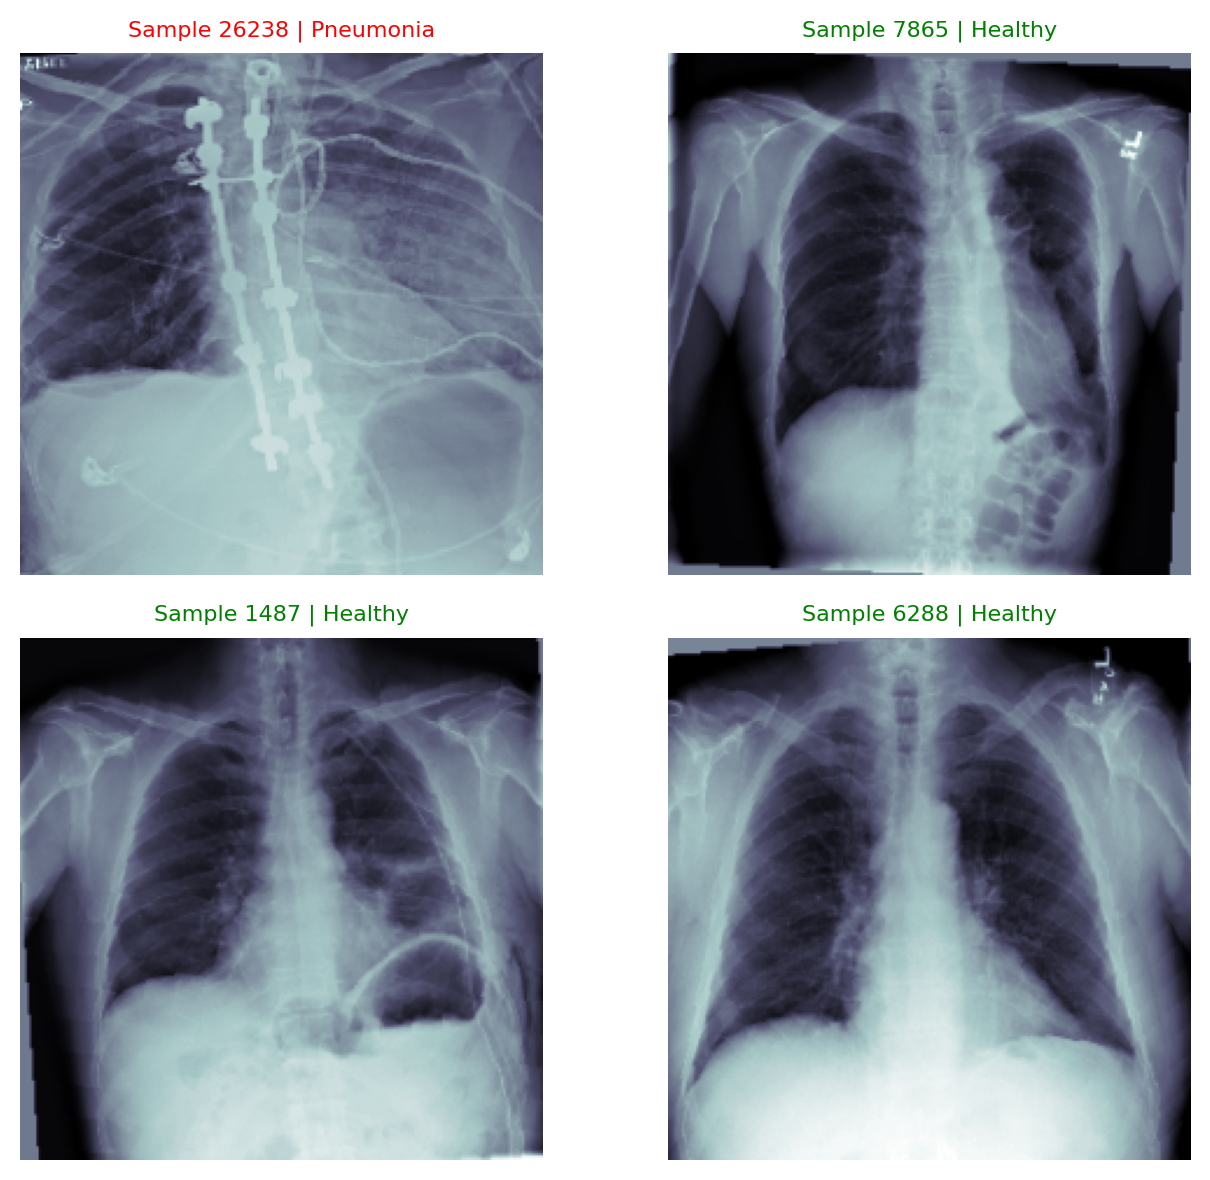

In [141]:
# DOES NOT WORK CORRECTLY
visualize_dataset_samples(train_dataset)

# 🧠 Unveiling the Power of `pl.LightningModule`: A Structured Approach to Neural Networks

Embarking on deep learning with PyTorch Lightning involves leveraging `pl.LightningModule`, a sophisticated blueprint that extends the foundational `torch.nn.Module` (1). While both serve as bases for neural networks, `pl.LightningModule` introduces an organized framework with automated functionalities for training, validation, and testing (2). Consider `torch.nn.Module` as providing individual bricks and cement, necessitating manual design and management of the entire construction. Conversely, `pl.LightningModule` offers pre-designed modules and automated machinery for crucial tasks, allowing you to focus on your model's architectural innovation and learning strategy.

## 💡 Deconstructing the Differences: `torch.nn.Module` vs. `pl.LightningModule`

- **`torch.nn.Module`**:
    - 🧱 Your primary responsibility is defining the network's structural components in the `__init__` method and orchestrating data flow in the `forward` method.
    - ✍️ Crafting training and validation loops, managing optimizers, handling device placement (CPU/GPU), and implementing logging are your sole responsibilities.

- **`pl.LightningModule`**:
    - 🏗️ You still implement `__init__` for architecture and `forward` for the computational graph.
    - ⚙️ However, you gain specialized methods delineating learning stages: training, validation, and optimization. **PyTorch Lightning then masterfully automates the execution of the underlying loops**, freeing you from boilerplate and potential pitfalls of manual loop implementation.

## 🔍 Navigating the Essential Methods of `pl.LightningModule`

1.  **`__init__(self, ...)`**:
    - 🛠️ As in `torch.nn.Module`, this is the constructor where you instantiate layers, modules, and learnable parameters forming your network's architecture.

2.  **`forward(self, x: torch.Tensor) -> torch.Tensor`**:
    - ➡️ This defines the computational graph, dictating how input `x` traverses the model's layers to produce output. It's semantically identical to `torch.nn.Module`'s `forward`.

3.  **`training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor`**:
    - 🚂 This is the core of training for a single data batch.
    - 📤 It receives a `batch` (input features and target labels) and `batch_idx` (batch number in the current epoch).
    - 🎯 Here, you compute model predictions and the loss quantifying the discrepancy between predictions and true labels.
    - 📊 Crucially, log training metrics (e.g., loss, accuracy) using `self.log`, accessible to PyTorch Lightning's logging.
    - 💰 The method must return the calculated `loss`, used by PyTorch Lightning for backpropagation and weight updates via the optimizer.

4.  **`validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor`**:
    - 🔬 Mirrors `training_step` but runs on the validation dataset.
    - 📥 Receives a validation `batch` and its `batch_idx`.
    - 📈 You compute predictions and the loss on validation data.
    - 📝 Similarly, log validation metrics (e.g., validation loss, accuracy) using `self.log`.
    - 📉 Should return the validation `loss`, usable by PyTorch Lightning for early stopping or other validation callbacks.

5.  **`configure_optimizers(self) -> List[torch.optim.Optimizer]`**:
    - ⚙️ This pivotal method defines and returns the optimizer(s) used to update model parameters during training.
    - 🗓️ Optionally, you can also return learning rate schedulers for dynamic learning rate adjustments.

### 💡 Exploring Optional yet Powerful Methods

-   **`validation_epoch_end(self, outputs: List[Any]) -> None`**:
    - 📊 Invoked at the end of each validation epoch.
    - 📤 Receives a list `outputs` from each `validation_step` of the epoch.
    - 📈 Here, aggregate these outputs to compute epoch-level validation metrics like average loss or overall accuracy.

-   **`test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None`**:
    - 🧪 Defines the evaluation logic for a single batch from your test dataset, analogous to `training_step` and `validation_step`.

-   **`predict_step(self, batch: torch.Tensor, batch_idx: int) -> Any`**:
    - 🔮 Outlines the inference or prediction process for an input `batch`, useful for obtaining raw model outputs without loss calculation.

## 📝 Illustrative Skeleton: A Simple Linear Model in PyTorch Lightning

```python
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torch

class MyLightningModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(10, 1)  # 🧱 Define a simple linear layer with 10 input features and 1 output feature

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(x)  # ➡️ Forward pass: data flows through the linear layer

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch  # 📦 Unpack the batch into input features (x) and target labels (y)
        y_hat = self(x)  # 📤 Pass the input through the model to get predictions (y_hat)
        loss = nn.functional.mse_loss(y_hat, y)  # 🎯 Calculate the mean squared error loss
        self.log("train_loss", loss)  # 📊 Log the training loss for monitoring
        return loss  # 💰 Return the loss for backpropagation

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch  # 📦 Unpack the validation batch
        y_hat = self(x)  # 📤 Get predictions on the validation data
        loss = nn.functional.mse_loss(y_hat, y)  # 📉 Calculate the validation loss
        self.log("val_loss", loss)  # 📈 Log the validation loss
        return loss  # 🔍 Return the validation loss

    def configure_optimizers(self) -> List[optim.Optimizer]:
        optimizer = optim.Adam(self.parameters(), lr=1e-3)  # ⚙️ Initialize the Adam optimizer with a learning rate of 0.001
        return [optimizer]  # ⚙️ Return a list containing the optimizer

## 🗒️ Concise Summary: Key Methods at a Glance

| Method                  | Required | Purpose                                      |
| :---------------------- | :------- | :------------------------------------------- |
| `__init__`              | Yes      | Define layers and model components           |
| `forward`               | Yes      | Implement the forward pass of the network    |
| `training_step`         | Yes      | Define the training logic for a single batch |
| `validation_step`       | No\* | Define the validation logic for a single batch |
| `configure_optimizers`  | Yes      | Specify the optimizer(s) to use              |
| `test_step`             | No       | Define the testing logic for a single batch  |
| `predict_step`          | No       | Define the prediction logic for a single batch |

\* While not strictly mandatory for a minimal implementation, `validation_step` is highly recommended for robust model development and evaluation.

---

**In essence:**
By adopting `pl.LightningModule`, you entrust the complexities of the training loop and its infrastructure to PyTorch Lightning. This strategic abstraction empowers you to concentrate on the core of your model – its architecture and the logic within each learning step. The outcome is cleaner, more reproducible code that is inherently easier to scale and manage.


# 🧠 Decoding "GELU Gain": Stabilizing Neural Networks with Smooth Activations

The concept of "GELU gain" arises from the necessity to carefully initialize neural network layer weights, especially when using the Gaussian Error Linear Unit (GELU) activation function (1). In deep learning, the initial configuration of a network's weights is crucial for stable gradient flow during training. Established initialization strategies, like He (for ReLU) and Xavier (for tanh), adjust initial weight variance to align with their respective activation functions (2, 3).

GELU, a modern and smoothly non-linear activation prevalent in architectures like transformers, poses a unique challenge. Its specific non-linearity means that standard initialization gains for ReLU or tanh might not be optimal. The "GELU gain" is an empirically derived scaling factor compensating for GELU's inherent variance reduction. Applying this gain during weight initialization aims to maintain consistent output variance relative to input variance across a layer. Practically, this gain can be approximated by propagating random data through GELU and quantifying the ratio of input to output standard deviation. Incorporating the appropriate gain during weight initialization can improve convergence speed and training stability when using GELU activations.

## ⚡ Deconstructing "Gain" in Activation Functions: A Scaling Lever for Neuron Output

In activation functions, **gain** is a multiplicative scaling factor applied to the function's output. It acts as a control, modulating the "strength" of the activation's response to its input, effectively amplifying or attenuating the signal propagated by a neuron.

### 💡 Analogous Perspective: The Auditory Volume Control

Listening to music through a speaker offers an analogy. The *activation function* is like the speaker's internal circuitry, determining if sound is produced based on the electrical signal (music waveform). The *gain* is analogous to the volume knob:

-   **Low Gain (Volume Attenuated):** Strong input signal (song) results in faint music.
-   **High Gain (Volume Amplified):** Identical input yields significantly louder sound.
-   **Zero Gain (Volume Muted):** No sound regardless of input intensity.

Just as the volume knob scales loudness, the gain parameter scales a neuron's output signal magnitude.

### 🧠 Biological Parallel: Neuronal Firing Sensitivity

Consider a biological neuron. The *activation function* mirrors the neuron's threshold for firing (action potential). The *gain* corresponds to the neuron's sensitivity to stimuli:

-   **High Gain:** Intense firing even with minimal stimulation.
-   **Low Gain:** Requires substantially stronger stimulus for noticeable firing.

### 🏗️ Mathematical Formulation

If $f(x)$ is an activation function, introducing gain modifies the output:

$$\text{output} = \text{gain} \times f(x)$$

For the sigmoid function:

$$\text{output} = \text{gain} \times \frac{1}{1 + e^{-x}}$$

-   **Gain > 1:** Output is amplified, neurons become more "excitable".
-   **Gain < 1:** Output is subdued, neurons become more "reserved".

### 🕹️ Systemic Interpretation: Gain as a Regulatory Mechanism

Imagine a neural network as a team of workers (neurons) with a lever (activation function) determining their work output based on instructions (inputs). Gain adjusts the lever's length. Longer levers (higher gain) allow easier lifting of heavy loads (large outputs), while shorter levers (lower gain) require more effort for the same output.

### 🩺 Clinical Illustration: Balancing Sensitivity in Medical Imaging AI

In medical imaging AI for tumor detection, a field of interest to you (4), excessively high activation gain could cause minor image artifacts to trigger false positive diagnoses. Conversely, too low gain might only detect prominent tumors, missing subtle but significant cases (false negatives). Appropriately adjusting gain balances the model's sensitivity (true positives) and specificity (avoiding false positives), akin to fine-tuning brightness and contrast on a medical display for diagnostic clarity.

---

## 💡 The Significance of Gain: Ensuring Stable and Adaptive Learning

-   **Stability**: Proper gain maintains neural activations within a range supporting effective learning, preventing exploding or vanishing gradients (5).
-   **Flexibility**: Adjustable gain allows a network to adapt to diverse data distributions and optimize for specific tasks. Different layers or neurons might benefit from varying gains.
-   **Interpretability**: Gain can act as a control on a neuron's "reactivity" to inputs, potentially offering insights into learned representations.

---

## 🛠️ Practical Implementation in PyTorch: Custom Activation with Controllable Gain

```python
import torch
import torch.nn as nn
from typing import Callable

class GainActivation(nn.Module):
    """
    Implements an activation function with an adjustable gain parameter.
    """
    def __init__(self, activation: Callable = torch.sigmoid, gain: float = 1.0):
        """
        Initializes the GainActivation module.

        Args:
            activation (Callable): The activation function to apply (default: torch.sigmoid).
            gain (float): The scalar gain multiplier (default: 1.0).
        """
        super().__init__()
        self.activation = activation
        self.gain = gain  # 📏 Gain is a scalar multiplier

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the activation function to the input and then scales the output by the gain.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying the activation and gain.
        """
        # 🧠 Apply the specified activation function and then scale the result by the gain
        return self.gain * self.activation(x)

# 🧪 Usage in a neural network layer
linear_layer = nn.Linear(10, 1)
gain_activation = GainActivation(activation=torch.relu, gain=0.5) # ReLU with a gain of 0.5

input_tensor = torch.randn(5, 10)
output_tensor = gain_activation(linear_layer(input_tensor)) # Output of the linear layer is passed through the gain-adjusted activation
print("Input Tensor Shape:", input_tensor.shape)
print("Output Tensor Shape:", output_tensor.shape)
print("\nSample Output (first row):", output_tensor[0].detach().numpy())

In [142]:
import torch
import torch.nn as nn
from typing import Optional # Not used in this snippet but good practice for module args

class MedicalAttentionGate(nn.Module):
    """
    🧠 A module that applies a learnable attention mechanism to an input tensor.

    This gate computes attention weights using a small neural network (two linear
    layers with sigmoid activations) and then uses these weights to scale the
    input tensor element-wise. This allows the model to emphasize or de-emphasize
    different features based on the input itself.
    """

    def __init__(self, dimension: int):
        """
        Initializes the MedicalAttentionGate.

        Args:
            dimension (int): The dimensionality of the input features (i.e., the size
                             of the last dimension of the input tensor). This dimension
                             is used for the linear layers.
        """
        super().__init__()

        # 🛠️ Robustness: Ensure the bottleneck dimension is at least 1.
        # The bottleneck size (dimension // 4) is a common choice, similar to
        # squeeze-and-excitation networks, to reduce parameters.
        # If dimension is too small (e.g., < 4), dimension // 4 could be 0.
        bottleneck_dimension = max(1, dimension // 4)
        if dimension < 4:
            print(f"⚠️ WARNING: Input dimension ({dimension}) is small. "
                  f"Bottleneck dimension set to {bottleneck_dimension}. "
                  f"Consider if this attention gate is suitable for such low dimensions.")

        # ⚙️ Architecture: The attention mechanism defined sequentially.
        # 1. Reduce dimension (squeeze): Linear layer followed by sigmoid.
        # 2. Restore dimension (excite): Linear layer followed by sigmoid to get weights in [0,1].
        self.attention_net = nn.Sequential(
            nn.Linear(dimension, bottleneck_dimension),
            nn.Sigmoid(),
            nn.Linear(bottleneck_dimension, dimension),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the attention mechanism to the input tensor.

        The input tensor `x` is expected to have its feature dimension (matching
        `self.dimension` from __init__) as its last dimension.
        Example shapes for x: (batch_size, dimension) or (batch_size, ..., dimension).

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The input tensor `x` scaled by the learned attention weights.
                          The output tensor has the same shape as `x`.
        """
        # 💬 Attention Mechanism: "Let me look at the input `x` and decide which parts are important."
        # `self.attention_net(x)` computes weights. `nn.Linear` operates on the last dim.
        # If x is (N, C, H, W) and you want channel attention, you'd typically apply this
        # after pooling H, W to get (N, C) or by adapting layers.
        # Assuming x is (..., dimension), attention_weights will be (..., dimension).
        attention_weights = self.attention_net(x)

        # 💬 Gating: "Now, I'll use these importance scores (weights) to rescale the original input."
        # Element-wise multiplication applies the attention.
        return x * attention_weights

In [143]:
class EnhancedClassifier(nn.Module):
    """
    🧠 An Enhanced Classifier with Attention and Custom Initialization.

    This module processes input features through a sequence of linear layers,
    batch normalization, GELU activations, dropout, and a `MedicalAttentionGate`,
    before producing the final classification logits. It features a custom
    weight initialization strategy tailored for GELU activations.
    """

    # Class variable to cache the empirically calculated GELU gain.
    # This avoids recomputing it for every instance of the classifier.
    _EMPIRICAL_GELU_GAIN: Optional[float] = None

    @staticmethod
    def _get_empirical_gelu_gain() -> float:
        """
        Calculates (or retrieves from cache) an empirical gain for GELU activation.
        The gain is estimated by comparing the standard deviation of a normally
        distributed random tensor before and after applying GELU.

        Returns:
            float: The calculated or cached empirical gain for GELU.
        """
        # 💬 GainStrategist: "Let's determine the optimal scaling factor for GELU."
        if EnhancedClassifier._EMPIRICAL_GELU_GAIN is None:
            # 🔬 Experiment: Perform a one-time calculation.
            with torch.no_grad(): # Ensure no gradient tracking for this utility calculation.
                # Using a reasonably large tensor for a stable estimate.
                # This tensor is created on the CPU by default.
                toy_input = torch.randn(100000)
                activated_output = nn.functional.gelu(toy_input)

                std_dev_input = toy_input.std().item()
                std_dev_output = activated_output.std().item()

                if std_dev_output == 0:
                    # This is unlikely for randn + GELU but a safe fallback.
                    print("⚠️ WARNING (EnhancedClassifier): GELU output standard deviation is zero "
                          "during empirical gain calculation. Defaulting GELU gain to 1.0.")
                    EnhancedClassifier._EMPIRICAL_GELU_GAIN = 1.0
                else:
                    EnhancedClassifier._EMPIRICAL_GELU_GAIN = std_dev_input / std_dev_output
                # 📊 Analyst: "Empirical gain for GELU calculated: {:.4f}".format(EnhancedClassifier._EMPIRICAL_GELU_GAIN)
        return EnhancedClassifier._EMPIRICAL_GELU_GAIN

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 dropout_rate: float = 0.3, # Renamed from 'dropout' for clarity
                 hidden_dim: int = 512):
        """
        Initializes the EnhancedClassifier.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features (e.g., number of classes).
            dropout_rate (float): Dropout probability for the dropout layers.
            hidden_dim (int): Dimensionality of the intermediate hidden layers.
        """
        super().__init__()
        # 🧱 Architect: "Designing the multi-stage feature processing pipeline."

        # First hidden layer expands features, second contracts before attention.
        hidden_dim_expanded = hidden_dim * 2

        self.feature_map_processor = nn.Sequential(
            nn.Linear(in_features, hidden_dim_expanded),
            nn.BatchNorm1d(hidden_dim_expanded), # Normalizes after first linear transform
            nn.GELU(),                           # Smooth, high-performing activation
            nn.Dropout(dropout_rate),            # Regularization

            nn.Linear(hidden_dim_expanded, hidden_dim),
            # Considerations for placement of BN/Activation around Attention:
            # Option 1: Attention on raw linear output (current implicit approach)
            # Option 2: Attention on normalized/activated features:
            #   nn.BatchNorm1d(hidden_dim),
            #   nn.GELU(),
            MedicalAttentionGate(hidden_dim), # Applies learned feature-wise attention

            nn.Dropout(dropout_rate / 2),        # Reduced dropout after attention
            nn.Linear(hidden_dim, out_features)  # Final layer for classification logits
        )

        # 💡 Weight Artisan: "Applying bespoke initialization to our layers."
        self._initialize_module_weights()

    def _initialize_module_weights(self) -> None:
        """
        Initializes weights of linear layers in the feature_map_processor.
        Uses a Kaiming-style normal initialization scaled by an empirically
        determined GELU gain. Biases are initialized to a small constant.
        """
        # 💬 Initializer: "Let's set the starting weights and biases thoughtfully."
        custom_gelu_gain = EnhancedClassifier._get_empirical_gelu_gain()

        # Iterate through all modules within the feature_map_processor.
        # Using .modules() is robust for nested nn.Sequential or custom modules.
        for module in self.feature_map_processor.modules():
            if isinstance(module, nn.Linear):
                # 📜 Kaiming He Initialization Principle: std = gain / sqrt(fan_mode_value)
                # We apply this using our custom 'custom_gelu_gain'.
                # 'fan_in' mode scales variance based on the number of input features,
                # which is common for forward passes.
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(module.weight)

                if fan_in == 0: # Should not happen with valid Linear layers
                    print(f"⚠️ WARNING (EnhancedClassifier): Fan-in is zero for a Linear layer. Skipping Kaiming-like init for its weights.")
                    # Initialize with a small default if fan_in is 0 to avoid division by zero
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                else:
                    std_deviation = custom_gelu_gain / math.sqrt(fan_in)
                    nn.init.normal_(module.weight, mean=0.0, std=std_deviation)

                # Initialize bias terms to a small constant.
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.1)
            # Can add elif for nn.BatchNorm1d if specific init needed, e.g.:
            # elif isinstance(module, nn.BatchNorm1d):
            #     nn.init.constant_(module.weight, 1.0) # Default
            #     nn.init.constant_(module.bias, 0.0)   # Default

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass through the enhanced classifier.

        Args:
            x (torch.Tensor): The input tensor.
                              Expected shape: (batch_size, in_features).

        Returns:
            torch.Tensor: The output tensor (logits).
                          Shape: (batch_size, out_features).
        """
        # ➡️ DataConductor: "Directing the input `x` through our sophisticated feature processor."
        return self.feature_map_processor(x)

In [144]:
pretrained_model_name = 'efficientnet_b3.ra2_in1k'
backbone = timm.create_model(
    pretrained_model_name,
    pretrained=True,
    num_classes=0,  # Remove original classifier
    global_pool=''  # Keep spatial dimensions
)
named_children = list(backbone.named_children())

In [145]:
for name, module in named_children:
    print(f"{name}: {module.__class__.__name__}\n\n")

conv_stem: Conv2d


bn1: BatchNormAct2d


blocks: Sequential


conv_head: Conv2d


bn2: BatchNormAct2d


global_pool: SelectAdaptivePool2d


classifier: Identity




### ❓ Explain `list(self.backbone.children())` vs `self.backbone.children()`. Does it make a difference in the case of the `PneumoniaModel` class workflow?

-----

## 🧠 Unraveling the Behavior of `.children()` in PyTorch

### 1️⃣ Dissecting the Difference: Generator vs. List

-   **`self.backbone.children()`**:
    -   👶 Think of `self.backbone` as a parent module in your network. `.children()` asks the parent to point out its direct offspring.
    -   🚶 It returns a **generator**, a type of iterator that yields children one by one when asked, without holding them all simultaneously (1).
    -   🚫 **Direct Indexing Incompatibility**: Being a generator, you can't directly access a specific child by index using square brackets, leading to a `TypeError`:
        ```python
        self.backbone.children()[0]
        # TypeError: 'generator' object is not subscriptable
        ```

-   **`list(self.backbone.children())`**:
    -   📸 This takes a "photograph" of all the immediate children. The `list()` function consumes the generator, iterating through all child modules and storing them in a standard Python **list** (2).
    -   🎯 **Index-Based Access Enabled**: With this list, you can readily access any child module by its index:
        ```python
        first_child = list(self.backbone.children())[0]
        ```

-----

### 🔍 Implications for the `PneumoniaModel` Workflow

-   **Correct Approach**: In `PneumoniaModel` (or any PyTorch Lightning model manipulating backbone layers by index), if you need to access a child module by its position (e.g., the first layer for feature extraction or freezing), you **must** convert the generator from `.children()` to a list first:

    ```python
    # ✅ Correct way to access the first layer
    self.first_layer = nn.Sequential(list(self.backbone.children())[:num_layers_to_freeze])
    ```

-   **Erroneous Approach**: Directly indexing the generator will cause a `TypeError`, halting your model's workflow:

    ```python
    # ❌ Incorrect and will raise an error
    self.first_layer = self.backbone.children()[0]
    # Raises: TypeError: 'generator' object is not subscriptable
    ```

-----

### 💡 Concise Summary

| Expression                      | Outcome                     |
| :------------------------------ | :-------------------------- |
| `list(self.backbone.children())` | ✅ Operates as expected      |
| `self.backbone.children()`      | ❌ Triggers a `TypeError`   |

-----

### ⚙️ System's Perspective: Memory Efficiency vs. Indexed Access

-   **Why Generators?**: PyTorch's `.children()` returns a generator for memory efficiency, especially in deep networks. Generators produce items on demand, avoiding simultaneous storage of all child modules, beneficial for single iterations (3).

-   **The Need for Lists**: When your workflow requires accessing specific child modules multiple times or by index (common for architectural interaction, freezing layers, or feature extraction), the generator's memory efficiency becomes a limitation. Converting to a list provides indexed access, at the cost of storing all child modules in memory.

-   **In `PneumoniaModel`**: Given the frequent need to interact with specific layers of a pre-trained backbone (e.g., for fine-tuning by freezing initial layers), using `list(self.backbone.children())` is necessary to enable indexed access to these layers.

-----

📝 **Concluding Thoughts**:
When working with child modules of a PyTorch `nn.Module`, remember that `.children()` provides a memory-efficient generator for iteration. However, if your `PneumoniaModel`'s workflow requires accessing these children by position, always wrap the `.children()` call in `list()` to allow indexing and slicing, ensuring you're working with a standard Python list for intended architectural interactions.

In [ ]:
class PneumoniaModel(nn.Module):
    def __init__(self,
                 pretrained_model_name: str,
                 # For binary classification (e.g., pneumonia vs. healthy)
                 num_classes: int = 1,
                 in_channels: int = 1,         # For grayscale medical images
                 criterion_pos_weight: float = 1.0,
                 classifier_hidden_dim: int = 512,    # Params for EnhancedClassifier
                 classifier_dropout_rate: float = 0.3,  # Params for EnhancedClassifier
                 img_size: int = 224):                 # For dummy input shape inference
        """
        Initializes the PneumoniaModel.

        Args:
            pretrained_model_name (str): Name of the timm pretrained model.
            num_classes (int): Number of output classes (1 for binary with BCEWithLogitsLoss).
            in_channels (int): Number of input image channels (e.g., 1 for grayscale).
            criterion_pos_weight (float): Weight for the positive class in BCEWithLogitsLoss.
            classifier_hidden_dim (int): Hidden dimension for the EnhancedClassifier.
            classifier_dropout_rate (float): Dropout rate for the EnhancedClassifier.
            img_size (int): Assumed image size (height/width) for dummy input pass.
        """
        super().__init__()
        self.pretrained_model_name = pretrained_model_name
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.img_size = img_size  # Store for dummy input

        # 🏥 Create backbone using timm
        # Prefer using timm's `in_chans` argument for robust input channel adaptation.
        # `num_classes=0` removes the original classifier head.
        # `global_pool=''` requests feature maps (N, C, H, W) rather than a pooled vector.
        try:
            self.backbone = timm.create_model(
                self.pretrained_model_name,
                pretrained=True,
                num_classes=0,          # Feature extraction mode
                global_pool='',         # Output feature maps
                in_chans=self.in_channels
            )
            print(
                f"✅ Backbone '{self.pretrained_model_name}' created with `in_chans={self.in_channels}` via timm.")
        except Exception as e_timm:
            # Fallback for models where `in_chans` might not be directly supported or fails
            print(
                f"⚠️ WARNING: Could not create backbone '{self.pretrained_model_name}' with timm's `in_chans={self.in_channels}`. Error: {e_timm}")
            print("     Attempting to create with default 3 input channels and then manually overriding the first conv layer (this is fragile).")
            self.backbone = timm.create_model(
                self.pretrained_model_name,
                pretrained=True,
                num_classes=0,
                global_pool=''
            )
            # Your original specific override was: self.backbone.conv_stem = nn.Conv2d(1, 40, ...)
            # This is highly model-specific. A more general (but still fragile) attempt:
            if self.in_channels != 3 and not self._attempt_manual_first_conv_override(self.in_channels):
                print(
                    f"❌ ERROR: Failed to adapt backbone for {self.in_channels} input channels. Model may not work as expected.")
                # Depending on requirements, you might raise an error here.

        # Since `global_pool=''` from timm returns feature maps (e.g., N, C, H, W),
        # we add adaptive pooling and flattening layers to prepare features for the classifier.
        self.global_adaptive_pool = nn.AdaptiveAvgPool2d(
            (1, 1))  # Pools to (N, C, 1, 1)
        self.flatten_features = nn.Flatten(
            start_dim=1)         # Flattens to (N, C)

        # Determine the number of output features (C) from the backbone using a dummy pass.
        # This is a robust way to get the feature dimension for the classifier.
        # Batch size 2 for BN robustness if any
        dummy_input = torch.randn(
            2, self.in_channels, self.img_size, self.img_size)
        self.backbone.eval()  # Set to eval mode for the dummy pass
        with torch.no_grad():  # No gradients needed for shape inference
            dummy_feature_maps = self.backbone(dummy_input)
        # Get C from (N, C, H, W)
        self.num_backbone_out_features = dummy_feature_maps.shape[1]
        self.backbone.train()  # Set back to train mode

        # 🧠 Add your custom classifier
        self.classifier = EnhancedClassifier(
            in_features=self.num_backbone_out_features,
            out_features=self.num_classes,
            dropout_rate=classifier_dropout_rate,
            hidden_dim=classifier_hidden_dim
        )

        # Loss function can be an attribute of the model or defined in the training script.
        self.criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(criterion_pos_weight, dtype=torch.float)
        )

        # Optimizers and metrics (Accuracy, AUROC) are now handled externally in the training script.

    def _attempt_manual_first_conv_override(self, target_in_channels: int) -> bool:
        """
        A fallback attempt to manually modify the first conv layer.
        This is fragile and model-dependent. `timm's in_chans` is preferred.
        Returns True if modification was attempted, False otherwise.
        """
        # Example for a model that has a 'conv_stem' like efficientnet variants
        if hasattr(self.backbone, 'conv_stem') and isinstance(self.backbone.conv_stem, nn.Conv2d):
            original_conv = self.backbone.conv_stem
            print(
                f"    Attempting to manually modify 'conv_stem' for {target_in_channels} input channels.")
            # The out_channels should ideally match the original layer's out_channels
            # or what the subsequent layer expects. The hardcoded '40' in your original
            # pl.LightningModule code was very specific.
            new_out_channels = original_conv.out_channels
            self.backbone.conv_stem = nn.Conv2d(
                target_in_channels, new_out_channels,
                kernel_size=original_conv.kernel_size,
                stride=original_conv.stride,
                padding=original_conv.padding,
                bias=(original_conv.bias is not None)
            )
            print(
                f"    Manually replaced 'conv_stem'. Output channels kept at {new_out_channels}.")
            return True
        # Add more model-specific checks here if needed for other architectures
        # e.g., for ResNets, often 'conv1'
        elif hasattr(self.backbone, 'conv1') and isinstance(self.backbone.conv1, nn.Conv2d):
            original_conv = self.backbone.conv1
            print(
                f"    Attempting to manually modify 'conv1' for {target_in_channels} input channels.")
            new_out_channels = original_conv.out_channels
            self.backbone.conv1 = nn.Conv2d(
                target_in_channels, new_out_channels,
                kernel_size=original_conv.kernel_size,
                stride=original_conv.stride,
                padding=original_conv.padding,
                bias=(original_conv.bias is not None)
            )
            print(
                f"    Manually replaced 'conv1'. Output channels kept at {new_out_channels}.")
            return True
        print(f"    ⚠️ Manual override: Could not find a known standard first Conv2d attribute ('conv_stem', 'conv1') to modify.")
        return False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass: Backbone feature extraction, pooling, flattening, and classification.
        """
        # x shape: (batch_size, self.in_channels, H, W)
        # Output: (batch_size, C_backbone, H_feat, W_feat)
        features_map = self.backbone(x)
        pooled_features = self.global_adaptive_pool(
            features_map)  # Output: (batch_size, C_backbone, 1, 1)
        # Output: (batch_size, C_backbone)
        flat_features = self.flatten_features(pooled_features)

        # Output: (batch_size, self.num_classes)
        logits = self.classifier(flat_features)

        # If binary classification (num_classes=1), squeeze the last dimension
        # to get (batch_size,) for BCEWithLogitsLoss compatibility.
        if self.num_classes == 1 and logits.ndim > 1 and logits.shape[1] == 1:
            return logits.squeeze(1)
        return logits

🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴

In [ ]:
# Callback Configuration
backbone_finetuning = BackboneFinetuning(
    unfreeze_backbone_at_epoch=10,
    lambda_func=lambda epoch: 1.5,
    backbone_initial_ratio_lr=0.1,
    train_bn=True,
    verbose=True
)

checkpointing = ModelCheckpoint(
    dirpath='clinical_models',
    filename='pneumonia-{epoch}-{val_auc:.2f}',
    monitor='val_auc',
    mode='max',
    save_top_k=3,
    save_last=True,
    auto_insert_metric_name=False
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    min_delta=0.005,
    check_finite=True,
    divergence_threshold=0.3
)

lr_monitor = LearningRateMonitor(logging_interval='step')
gradient_accumulation = GradientAccumulationScheduler(scheduling={0: 2, 20: 4})
swa = StochasticWeightAveraging(swa_lrs=1e-4, annealing_epochs=5)

# Trainer Configuration
trainer = pl.Trainer(
    accelerator="gpu",
    devices=2,
    max_epochs=50,
    callbacks=[
        backbone_finetuning,
        checkpointing,
        early_stopping,
        lr_monitor,
        gradient_accumulation,
        swa
    ],
    logger=pl.loggers.TensorBoardLogger(
        save_dir=str(Path.cwd()),
        name="clinical_logs",
        # version="pneumonia_v1"
    ),
    log_every_n_steps=25,
    enable_progress_bar=True,
    precision='16-mixed'
)

In [ ]:
model = PneumoniaModel()
trainer.fit(model, train_loader, val_loader)

In [ ]:
trainer.fit(model, train_loader, val_loader)

In [ ]:


# def clear_memory():
#     # Delete variables if they exist in the current global scope
#     if "inputs" in globals():
#         del globals()["inputs"]
#     if "model" in globals():
#         del globals()["model"]
#     if "processor" in globals():
#         del globals()["processor"]
#     if "trainer" in globals():
#         del globals()["trainer"]
#     if "peft_model" in globals():
#         del globals()["peft_model"]
#     if "bnb_config" in globals():
#         del globals()["bnb_config"]
#     time.sleep(2)

#     # Garbage collection and clearing CUDA memory
#     gc.collect()
#     time.sleep(2)
#     torch.cuda.empty_cache()
#     torch.cuda.synchronize()
#     time.sleep(2)
#     gc.collect()
#     time.sleep(2)

#     print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
#     print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


# clear_memory()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model=PneumoniaModel.load_from_checkpoint(...)
model.eval()
model.to(device)

In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds = torch.Tensor(preds)
labels = torch.Tensor(labels).int()

In [ ]:
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task="binary", num_classes=2)(preds, labels)
threshed_confusion_matrix = torchmetrics.ConfusionMatrix(
    task="binary", num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {confusion_matrix}\n")
print(f"Confusion Matrix 2:\n {threshed_confusion_matrix}")

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

nrows, ncols = axis.shape
for i in range(nrows):
    for j in range(ncols):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(
            f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")